In [13]:
import sys
sys.path.append('/home/allen_kuo/reinforcement-learning/formula1')
from lib import *
import math
from random import randint, choice
from gym.envs.classic_control import CartPoleEnv
import tensorflow as tf
import pandas as pd
import numpy as np
import heapq
from random import random, sample
from IPython import display
import matplotlib.pyplot as plt

In [21]:
batch_size = 256
T = batch_size*100
GAMMA = 0.99
reward_decay = 1.0
mu_decay = 0.999
learning_rate = 0.001
update_target_network_time = 1000
units = 32
action_size = 2
ACTIONS = ['left', 'right']
n_layers = 4

In [24]:
# common part is cnn1-cnn1-fc
def build_network():
    with tf.variable_scope('Action-Critic-Network-Common', reuse=tf.AUTO_REUSE):
        layers = [0]*layer_n
        inputs = tf.placeholder(shape=(None, 4), dtype=tf.float32) # track image
        layers[0] = tf.layers.dense(inputs=inputs, units=units, activation=tf.nn.tanh, name='layer_0')
        for i in range(n_layers-1):
            layers[i+1] = tf.layers.dense(inputs=layers[i], units=units, activation=tf.nn.tanh, name='layer_%d'%(i+1))
            
        outputs = tf.layers.dense(inputs=layers[-1], units=action_size, activation=tf.nn.softmax)

    return inputs, outputs

In [40]:
class ACNetwork:
    def __init__(self):
        self.action_size = len(ACTIONS)
        self.output_size = 1
        self.model_folder = './model/actor_critic_network'
        
        self.advantage = tf.placeholder(shape=(None, self.action_size), dtype=tf.float32, name='advantage')
        self.rewards = tf.placeholder(shape=(None), dtype=tf.float32, name='rewards')
        self.global_step = tf.Variable(0, dtype=tf.int32)
        
        inputs, output = build_network()
        self.inputs = inputs
        self.common = output
    
        self.policy_metrics = {}
        self.policy_metrics['loss'] = []
        
        self.value_metrics = {}
        self.value_metrics['loss'] = []
        
        with tf.variable_scope('policy-network'):
            self.actions_values = tf.layers.dense(output, units=self.action_size, activation=tf.nn.softmax) # batch_size, action_size
            self.best_action = tf.argmax(self.actions_values, axis=1)

            self.policy_loss = tf.reduce_sum(tf.log(self.actions_values) * self.advantage)*-1
            
        with tf.variable_scope('value-network'):
            self.state_value = tf.layers.dense(output, units=self.output_size)
            self.value_loss = tf.reduce_sum(tf.square(self.state_value - self.rewards))
        
        self.loss = self.policy_loss + self.value_loss
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        self.train_op = self.do_clipping(self.loss, optimizer)

        self.sess = tf.Session()
        self.target_sess = tf.Session()
        
        self.sess.run(tf.global_variables_initializer())
        self.target_sess.run(tf.global_variables_initializer())

        self.saver = tf.train.Saver()
        
    def do_clipping(self, loss, optimizer):
        grad_vars = optimizer.compute_gradients(loss)
        self.grad_vars = [
          (tf.clip_by_norm(grad, clip_norm=10), var)
          for grad, var in grad_vars if grad is not None
        ]
        self.grad_dict = dict([
          [var.name, grad]
          for grad, var in self.grad_vars
        ])

        train_step = optimizer.apply_gradients(self.grad_vars, global_step=self.global_step)
        return train_step
    
    def get_action(self, state):
        best_action = self.target_sess.run(self.best_action, feed_dict={self.inputs: [state]})[0]
        return best_action
        
    def get_state_values(self, states):
        state_values = self.target_sess.run(self.state_value, feed_dict={self.inputs: states})
        return state_values
    
    def get_state_value(self, state):
        return self.get_state_values([state])[0]
    
    def get_advantages(self, batch):
        advantages = []
        for transaction in batch:
            # unselected actions get 0 advantage, selected action get reward - current_state_value advantage
            advantage = [0]*self.action_size
            advantage[transaction['action']] = transaction['advantage']

            advantages.append(advantage)
            
        advantages = np.array(advantages)
        return advantages

    def update(self, batch):
        states = [transaction['state'] for transaction in batch]
        advantages = self.get_advantages(batch)
        rewards = [transaction['reward'] for transaction in batch]
        
        return self.sess.run([self.train_op, self.loss], feed_dict={self.inputs: states, self.advantage: advantages, self.rewards: rewards})
        
    def reload(self, model_name):
        self.saver.save(self.sess, '%s/%s'%(self.model_folder, model_name))
        self.saver.restore(self.target_sess, tf.train.latest_checkpoint(self.model_folder))

KeyboardInterrupt: 

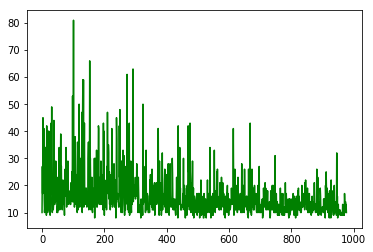

In [41]:
tf.reset_default_graph()

D = Memory(T)
ac_network = ACNetwork()

env = CartPoleEnv()
#env.theta_threshold_radians = 2 * math.pi * 1/4
state = env.reset()
state = state.tolist()

metrics  = {}
metrics['loss'] = [0]
metrics['label'] = []
metrics['round_length'] = []

t = 0
one_round = []
mu = 1.0

for rid in range(2000000):
    #env.render()
    if random() < mu:
        action = env.action_space.sample()
    else:
        action = ac_network.get_action(state)
    
    next_state, reward, done, _ = env.step(action) # take a random action
    next_state = next_state.tolist()
    
    transaction = Transaction((state, action, reward, next_state, None))
    #D.insert(transaction)
    one_round.append(transaction)
    state = next_state

    batch = D.batch(batch_size)
    if batch.any() and batch is not None:
        #add_label(batch, Q, GAMMA)
        _, loss = ac_network.update(batch)
        
        metrics['loss'].append(loss)
    
    #print(transaction, batch)    
    if done:
        reward = 0
        for transaction in reversed(one_round):
            reward += transaction['reward']
            reward *= reward_decay
            transaction['reward'] = reward
            
        add_advantage(one_round, ac_network)
        
        for transaction in one_round:
            D.insert(transaction)
            
        metrics['round_length'].append(len(one_round))
        one_round = []
            
        state = env.reset()
        state = state.tolist()
        
        mu *= mu_decay

    if rid > 0 and rid % update_target_network_time == 0:
        ac_network.reload(str(rid))
        
    if rid > 0 and rid % 1000 == 0:
        #plt.plot(metrics['action'][0], metrics['action'][1], 'g', metrics['best_action'][0], metrics['best_action'][1], 'y')        
        print(mu, rid, len(metrics['round_length']), len(one_round))
        
        length = metrics['round_length']
        #range_size = max(1, len(length)/100)
        #range_size = 100
        #length = [np.mean(length[i:i+range_size]) for i in range(0, len(length), range_size)]
        plt.gcf().clear()
        plt.plot(length, 'g')
        display.display(plt.gcf())
        display.clear_output(wait=True)



In [3]:
def plot(series, range_size):
    series = [np.mean(series[i:i+range_size]) for i in range(0, len(series), range_size)]
    plt.plot(series, 'y')
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [4]:
def show_state(env, img, step=0, info=""):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [34]:
mu

0.3564662036919788

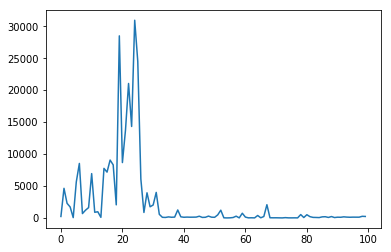

In [53]:
length = metrics['round_length'][200:300]
range_size = 1
length = [np.mean(length[i:i+range_size]) for i in range(0, len(length), range_size)]
plt.plot(length)

In [56]:
get_labels(D.batch(100))

[array([1975529.2, 1910659.8], dtype=float32),
 array([1964313.8, 1975825. ], dtype=float32),
 array([1988715.9, 1965539.8], dtype=float32),
 array([1983933.5, 1962782.8], dtype=float32),
 array([1979743.9, 1854555.5], dtype=float32),
 array([1976056.2, 1977378. ], dtype=float32),
 array([1980868.6, 1853415.5], dtype=float32),
 array([1972957.1, 1939484. ], dtype=float32),
 array([1988222.8, 1966350.9], dtype=float32),
 array([1984209.5, 1984600.9], dtype=float32),
 array([1980725.5, 1858997.2], dtype=float32),
 array([1985271.9, 1964155.9], dtype=float32),
 array([1986444. , 1974376.2], dtype=float32),
 array([1990744.4, 1961530.4], dtype=float32),
 array([1981108. , 1963468.6], dtype=float32),
 array([1949322.6, 1972167. ], dtype=float32),
 array([1991731.5, 1970472.8], dtype=float32),
 array([1991866.5, 1959029.9], dtype=float32),
 array([1983595.5, 1963789.5], dtype=float32),
 array([1988132.6, 1968003.5], dtype=float32),
 array([1975919.9, 1963347. ], dtype=float32),
 array([19796